<a href="https://colab.research.google.com/github/Gimmi-07/FFML_Projects_and_Labs/blob/main/FFML_Module_09%2CLAB_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT

FMML Module 09, Lab 04 <br>
 NAME: Grishma Yenchilwar ( grishma.yenchilwar.cse@ghrce.raisoni.net ) <br>
 Date: 06 May 2024 <br>

 Module 9: Convolutional Neural Networks<br>
 Lab 4<br>
 Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-10 15:56:03--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.126, 18.160.200.71, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   134MB/s    in 0.3s    

2024-05-10 15:56:04 (134 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


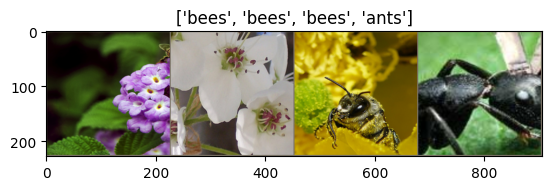

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.2MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5778 Acc: 0.7049

Epoch 1/4
----------
Loss: 0.3818 Acc: 0.8484

Epoch 2/4
----------
Loss: 0.4500 Acc: 0.8238

Epoch 3/4
----------
Loss: 0.5610 Acc: 0.7664

Epoch 4/4
----------
Loss: 0.4554 Acc: 0.8197



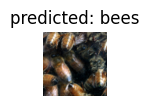

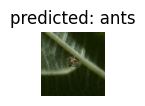

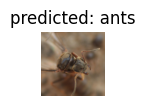

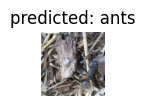

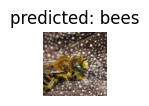

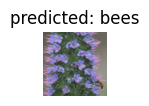

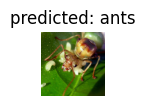

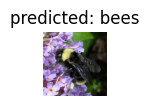

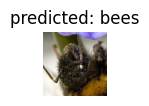

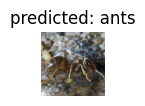

In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


1) Data augmentation techniques such as resizing, cropping, rotating, flipping, and adjusting brightness or contrast are crucial in training machine learning models, particularly for tasks like image classification, object detection, and segmentation. Here's why they're significant:

1. **Increased Robustness**: Data augmentation helps to create a more robust
model by exposing it to variations in the input data. By augmenting the training data with variations of the original images, the model learns to generalize better and becomes more robust to changes in the input during inference. For example, a classifier trained on images of cats should still perform well even if the cats are in different positions, orientations, or sizes.

2. **Regularization**: Augmentation acts as a form of regularization, helping to prevent overfitting by artificially expanding the training dataset. This can improve the model's ability to generalize to unseen data by reducing the risk of memorizing noise or irrelevant patterns in the training data.

3. **Increased Diversity**: Data augmentation increases the diversity of the training data, which is particularly beneficial when the original dataset is limited in size. By generating new samples from existing ones, data augmentation allows the model to learn from a more diverse set of examples, potentially capturing a wider range of features and patterns.

4. **Reduced Bias**: Augmenting the training data can help reduce bias in the model by ensuring that it is exposed to a more representative sample of the underlying data distribution. This is especially important in domains where the training data may be biased towards certain classes or characteristics.

5. **Improved Generalization**: Ultimately, data augmentation contributes to improved generalization performance of machine learning models. By training on augmented data, models can learn to better adapt to variations and complexities present in real-world data, leading to better performance on unseen examples.


2) If we don't use a pre-trained ResNet model and instead train the model from scratch, we may observe lower performance compared to using a pre-trained model, especially if we have a relatively small dataset.

When wetrain a deep learning model from scratch without pre-training, the model starts with randomly initialized weights. This means that initially, the model has no knowledge about the task it's supposed to perform. It needs to learn meaningful representations of the data solely based on the training examples provided. This can be challenging, especially for deep networks with many parameters.

Without pre-training, the model requires more data and computational resources to converge to a good solution. It might also be prone to overfitting, particularly if the dataset is small. Additionally, training from scratch may take longer compared to fine-tuning a pre-trained model, as the model has to learn all features from scratch rather than building on pre-existing knowledge.

To evaluate the performance of training a ResNet model without using pre-trained weights, you would typically follow these steps:

1. **Model Initialization**: Initialize the ResNet model with random weights instead of pre-trained weights.
2. **Training**: Train the model on your dataset using techniques like data augmentation, appropriate loss functions, and optimization algorithms (e.g., stochastic gradient descent, Adam).
3. **Evaluation**: Evaluate the trained model on a separate validation set to assess its performance in terms of metrics like accuracy, precision, recall, F1-score, etc.
4. **Fine-tuning**: Optionally, you may perform hyperparameter tuning or adjust the architecture of the model to improve performance further.

The performance you achieve would depend on various factors such as the size and quality of your dataset, the complexity of the task, the architecture of the model, the training hyperparameters, and any regularization techniques applied.

3) Using a pre-trained ResNet model that was trained on a significantly different dataset can still provide benefits, but the performance may not be as good as if the pre-trained model were trained on a dataset more similar to the task at hand (such as the ants vs. bees dataset).

Here are some points to consider:

1. **Transfer Learning**: Pre-trained models leverage transfer learning, where knowledge gained from solving one problem is applied to a different but related problem. While the features learned by the pre-trained ResNet model may not directly correspond to the features relevant to the ants vs. bees classification task, they can still capture generic features like edges, textures, and shapes that are useful across many visual recognition tasks.

2. **Fine-Tuning**: Even though the pre-trained model may have learned features that are not directly applicable to the ants vs. bees task, you can fine-tune the model on the new dataset to adapt it to the specific characteristics of the task. Fine-tuning involves unfreezing some of the layers in the pre-trained model and updating their weights during training while keeping the rest of the model frozen or using a very low learning rate. This allows the model to adjust its learned representations to better suit the target task.

3. **Limited Adaptation**: However, there are limitations to how well a pre-trained model can adapt to a significantly different dataset. If the pre-trained model learned features that are fundamentally dissimilar to those relevant to the new task, its performance may be limited. In such cases, training a model from scratch or using a pre-trained model that is more closely aligned with the target task may yield better results.

4. **Dataset Size**: The size and diversity of the new dataset also play a crucial role. If the ants vs. bees dataset is relatively small, using a pre-trained model can still provide regularization benefits and help prevent overfitting. However, if the dataset is large enough, training a model from scratch might be a viable option.

